# Riddler Battle Royale



> [538's *The Riddler* Asks](http://fivethirtyeight.com/features/the-battle-for-riddler-nation-round-2/): *In a distant, war-torn land, there are 10 castles. There are two warlords: you and your archenemy, with whom you’re competing to collect the most victory points. Each castle has its own strategic value for a would-be conqueror. Specifically, the castles are worth 1, 2, 3, …, 9, and 10 victory points. You and your enemy each have 100 soldiers to distribute, any way you like, to fight at any of the 10 castles. Whoever sends more soldiers to a given castle conquers that castle and wins its victory points. If you each send the same number of troops, you split the points. You don’t know what distribution of forces your enemy has chosen until the battles begin. Whoever wins the most points wins the war. Submit a plan distributing your 100 soldiers among the 10 castles.*



In [1]:
# Load some useful modules
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import random
from collections import Counter
from statistics import mean

Let's play with this and see if we can find a good solution. Some implementation choices:
* A `Plan` will be a tuple of 10 soldier counts (one for each castle).
* `castles` will hold the indexes of the castles. Note that index 0 is castle 1 (worth 1 point) and index 9 is castle 10 (worth 10 points).
* `half` is half the total number of points; if you get more than this you win.
* `plans` will hold a set of plans that were submitted in the previous contest.
* `play(A, B)` gives the single game reward for Plan A against Plan B: 1 if A wins, 0 if A loses, and 1/2 for a tie.
* `reward(a, b, payoff)` returns payoff, payoff/2, or 0, depending on whether `a` is bigger than `b`.

In [2]:
Plan    = tuple      
castles = range(10)
half    = 55/2     
plans   = {Plan(map(int, row[:10])) 
           for row in csv.reader(open('battle_royale.csv'))}

def play(A, B): 
    "Play Plan A against Plan B and return a reward (0, 1/2, or 1)."
    A_points = sum(reward(A[c], B[c], c + 1) for c in castles)
    return reward(A_points, half) 

def reward(a, b, payoff=1): return (payoff if a > b else payoff / 2 if a == b else 0) 

Some tests:

In [3]:
assert reward(6, 5, 9) == 9  # 6 soldiers defeat 5, winning all 9 of the castle's points
assert reward(6, 6, 8) == 4  # A tie on an 8-point castle is worth 4 points
assert reward(6, 7, 7) == 0  # No points for a loss
assert reward(30, 25)  == 1  # 30 victory points beats 25

assert len(plans) == 1202

assert play((26, 5, 5, 5, 6, 7, 26, 0,  0, 0),
            (25, 0, 0, 0, 0, 0, 0, 25, 25, 25)) == 1 # A wins game

assert play((26, 5, 5, 5, 6, 7, 26, 0,  0, 0),
            (0, 25, 0, 0, 0, 0, 0, 25, 25, 25)) == 0 # B wins game

assert play((25, 5, 5, 5, 6, 7, 26, 0,  0, 0),
            (25, 0, 0, 0, 0, 0, 0, 25, 25, 25)) == 1/2 # Tie game

Let's run a tournament, playing each plan against every other, and returning a list of `[(plan, mean_game_points),...]`.  I will also define `show` to pretty-print these results and display a histogram:

In [4]:
def tournament(plans):
    "Play each plan against each other; return a sorted list of [(plan: mean_points)]"
    rankdict = {A: mean_points(A, plans) for A in plans}
    return Counter(rankdict).most_common()

def mean_points(A, opponents): 
    "Mean points for A playing against all opponents (but not against itself)."
    return mean(play(A, B) for B in opponents if B is not A)

def show(rankings, n=10): 
    "Pretty-print the n best plans, and display a histogram of all plans."
    print('Top', n, 'of', len(rankings), 'plans:')
    for (plan, points) in rankings[:n]:
        print(pplan(plan), pct(points))
    plt.hist([s for (p, s) in rankings], bins=20)
    
def pct(x): return '{:6.1%}'.format(x)
def pplan(plan): return '(' + ', '.join('{:2}'.format(c) for c in plan) + ')'

In [5]:
# This is what the result of a tournament looks like:
tournament({(26, 5, 5, 5, 6, 7, 26, 0,  0, 0),
            (25, 0, 0, 0, 0, 0, 0, 25, 25, 25),
            (0, 25, 0, 0, 0, 0, 0, 25, 25, 25)})

[((0, 25, 0, 0, 0, 0, 0, 25, 25, 25), 1),
 ((26, 5, 5, 5, 6, 7, 26, 0, 0, 0), 0.5),
 ((25, 0, 0, 0, 0, 0, 0, 25, 25, 25), 0)]

Top 10 of 1202 plans:
( 0,  3,  4,  7, 16, 24,  4, 34,  4,  4)  85.6%
( 5,  7,  9, 11, 15, 21, 25,  2,  2,  3)  84.1%
( 3,  5,  8, 10, 13,  1, 26, 30,  2,  2)  83.3%
( 2,  2,  6, 12,  2, 18, 24, 30,  2,  2)  83.3%
( 2,  8,  2,  2, 10, 18, 26, 26,  3,  3)  83.2%
( 3,  6,  7,  9, 11,  2, 27, 31,  2,  2)  83.2%
( 1,  1,  1,  5, 11, 16, 28, 29,  3,  5)  82.8%
( 1,  3,  1,  1, 17, 20, 21, 30,  3,  3)  82.6%
( 3,  6, 10, 12, 16, 21, 26,  2,  2,  2)  82.4%
( 6,  6,  6, 11, 20, 21, 21,  3,  3,  3)  82.2%


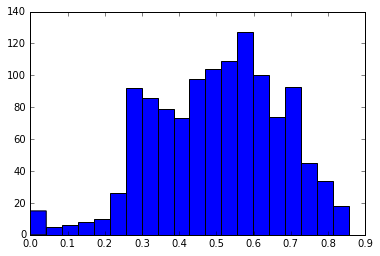

In [6]:
# A tournament with all 1202 plans:
rankings = tournament(plans)
show(rankings)

It looks like there are a few really bad plans in there.  Let's just keep the top 1000 plans (out of 1202), and re-run the rankings:

Top 10 of 1000 plans:
( 0,  3,  4,  7, 16, 24,  4, 34,  4,  4)  87.4%
( 5,  5,  5,  5,  5,  5, 27, 30,  6,  7)  84.8%
( 5,  5,  5,  5,  5,  5, 30, 30,  5,  5)  84.2%
( 3,  3,  5,  5,  7,  7, 30, 30,  5,  5)  84.1%
( 1,  2,  3,  4,  6, 16, 25, 33,  4,  6)  82.5%
( 2,  2,  2,  5,  5, 26, 26, 26,  3,  3)  82.4%
( 1,  1,  1,  5, 11, 16, 28, 29,  3,  5)  82.0%
( 0,  1,  3,  3, 11, 18, 25, 33,  3,  3)  82.0%
( 5,  7,  9, 11, 15, 21, 25,  2,  2,  3)  81.7%
( 0,  0,  5,  5, 25,  3, 25,  3, 31,  3)  81.5%


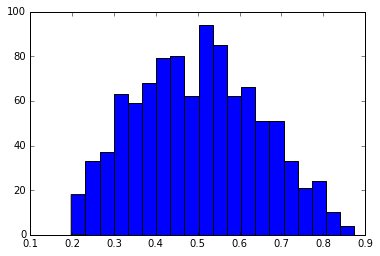

In [7]:
plans = {A for (A, _) in rankings[:1000]}
rankings = tournament(plans)
show(rankings)

The top 10 plans are still winning over 80%, and the top plan remains `(0, 3, 4, 7, 16, 24, 4, 34, 4, 4)`. This is an interesting plan: it places most of the soldiers on castles 4+5+6+8, which totals only 23 points, so it needs to pick up 5 more points from the other castles (that have mostly 4 soldiers attacking each one). Is this a good strategy? Where should we optiomally allocate soldiers? 

To gain some insight, I'll create a plot with 10 curves, one for each castle. Each curve maps the number of soldiers sent to the castle (on the x-axis) to the expected points won (against the 1000 plans) on the y-axis:


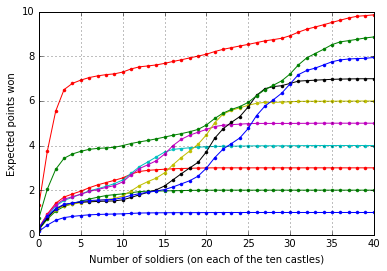

In [8]:
def plotter(plans, X=range(41)):
    X = list(X)
    def mean_reward(c, s): return mean(reward(s, p[c], c+1) for p in plans)
    for c in range(10):
        plt.plot(X, [mean_reward(c, s) for s in X], '.-')
    plt.xlabel('Number of soldiers (on each of the ten castles)')
    plt.ylabel('Expected points won')
    plt.grid()
        
plotter(plans)

For example, this says that for castle 10 (the orange line at top), there is a big gain in expected return as we increase from 0 to 4 soldiers, and after that the gains are relatively less steep. This plot is interesting, but I can't see how to directly read off a best plan from it.

## Hillclimbing

Instead I'll see if I can improve the existing plans, using a simple *hillclimbing* strategy: Take a Plan A, and change it by randomly moving some soldiers from one castle to another. If that yields more `mean_points`, then keep the updated plan, otherwise discard it. Repeat.

In [9]:
def hillclimb(A, plans=plans, steps=1000):
    "Try to improve Plan A, repeat `steps` times; return new plan and total."
    m = mean_points(A, plans)
    for _ in range(steps):
        B = mutate(A)
        m, A = max((m, A), 
                   (mean_points(B, plans), B))
    return A, m

def mutate(plan):
    "Return a new plan that is a slight mutation."
    plan = list(plan) # So we can modify it.
    i, j = random.sample(castles, 2)
    plan[i], plan[j] = random_split(plan[i] + plan[j])
    return Plan(plan)

def random_split(n):
    "Split the integer n into two integers that sum to n."
    r = random.randint(0, n)
    return r, n - r

Let's see how well this works. Remember, the best plan so far had a score of `87.4%`. Can we improve on that?

In [10]:
hillclimb((0, 3, 4, 7, 16, 24, 4, 34, 4, 4))

((0, 3, 4, 15, 7, 21, 3, 31, 3, 13), 0.916)

We got an improvement. Let's see what happens if we start with other plans:

In [11]:
hillclimb((10, 10, 10, 10, 10, 10, 10, 10, 10, 10))

((0, 5, 5, 12, 7, 22, 3, 31, 3, 12), 0.912)

In [12]:
hillclimb((0, 1, 2, 3, 4, 18, 18, 18, 18, 18))

((1, 3, 4, 14, 7, 21, 3, 31, 4, 12), 0.9105)

In [13]:
hillclimb((2, 3, 5, 5, 5, 20, 20, 20, 10, 10))

((0, 5, 5, 15, 7, 21, 3, 31, 6, 7), 0.9065)

In [14]:
hillclimb((0, 0, 5, 5, 25, 3, 25, 3, 31, 3))

((0, 2, 6, 7, 18, 1, 26, 2, 32, 6), 0.8855)

What if we hillclimb 20 times longer?

In [15]:
hillclimb((0, 3, 4, 7, 16, 24, 4, 34, 4, 4), steps=20000)

((0, 5, 6, 14, 9, 21, 3, 31, 3, 8), 0.9065)

## Opponent modeling

To have a chance of winning the second round of this contest, we have to predict what the other entries will be like. Nobody knows for sure, but I can hypothesize that the entries will be slightly better than the first round, and try to approximate that by hillclimbing from each of the first-round plans for a small number of steps:

In [16]:
def hillclimbers(plans, steps=100):
    "Return a sorted list of [(improved_plan, mean_points), ...]"
    pairs = {hillclimb(plan, plans, steps) for plan in plans}
    return sorted(pairs, key=lambda pair: pair[1], reverse=True)

In [17]:
# For example:
hillclimbers({(26, 5, 5, 5, 6, 7, 26, 0,  0, 0),
              (25, 0, 0, 0, 0, 0, 0, 25, 25, 25),
              (0, 25, 0, 0, 0, 0, 0, 25, 25, 25)})

[((29, 19, 2, 10, 6, 5, 3, 1, 25, 0), 1),
 ((11, 9, 18, 3, 1, 11, 0, 27, 0, 0), 1),
 ((0, 25, 0, 0, 0, 0, 0, 25, 25, 25), 1)]

I will define `plans2` (and `rankings2`) to be my estimate of the entries for round 2:

CPU times: user 6min 11s, sys: 3.21 s, total: 6min 14s
Wall time: 6min 17s
Top 10 of 1000 plans:
( 1,  4,  5, 15,  6, 21,  3, 31,  3, 11)  90.8%
( 0,  3,  5, 14,  7, 21,  3, 30,  4, 13)  90.6%
( 0,  4,  6, 15,  9, 21,  4, 31,  5,  5)  90.2%
( 2,  4,  3, 13,  5, 22,  3, 32,  4, 12)  90.1%
( 0,  3,  5, 15,  8, 21,  4, 32,  6,  6)  90.0%
( 0,  3,  5, 15,  6, 24,  3, 31,  5,  8)  90.0%
( 0,  3,  6, 13,  6, 21,  5, 30,  4, 12)  90.0%
( 3,  4,  5, 15,  7, 21,  2, 31,  6,  6)  89.9%
( 2,  3,  3, 13,  6, 21,  3, 30,  5, 14)  89.8%
( 0,  2,  2, 12,  2, 23,  4, 31,  3, 21)  89.8%


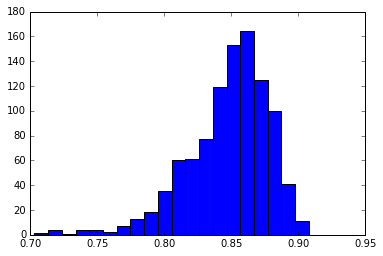

In [18]:
%time rankings2 = hillclimbers(plans)
plans2 = {A for (A, _) in rankings2}
show(rankings2)

Even though we only took 100 steps, the `plans2` plans are greatly improved: Almost all of them defeat 75% or more of the first-round `plans`. The top 10 plans are all very  similar, targeting castles 4+6+8+10 (for 28 points), but reserving 20 or soldiers to spread among the other castles. Let's look more carefully at every 40th plan, plus the last one:

In [21]:
for (p, m) in rankings2[::40] + [rankings2[-1]]:
    print(pplan(p), pct(m))

( 1,  4,  5, 15,  6, 21,  3, 31,  3, 11)  90.8%
( 0,  6,  3, 13,  3, 22,  2, 32,  4, 15)  88.9%
( 1,  3,  6, 13,  9, 22,  1, 30,  4, 11)  88.3%
( 2,  2,  1, 13,  3, 21,  2, 32,  3, 21)  87.9%
( 0,  2,  5,  5, 15,  2, 28, 31,  5,  7)  87.6%
( 2,  2,  4, 14,  9,  1, 27, 30,  6,  5)  87.3%
( 3,  2,  3, 12,  3, 28,  3, 32,  6,  8)  87.0%
( 1,  3,  2,  5, 18,  3, 26,  3, 33,  6)  86.7%
( 0,  4,  4,  6, 15,  3, 29, 30,  5,  4)  86.5%
( 5,  5,  4,  5, 13, 22,  2, 29,  3, 12)  86.2%
( 5,  6,  5,  6, 16, 24, 26,  1,  5,  6)  85.9%
( 0,  2,  5, 15,  8,  3, 20, 36,  6,  5)  85.7%
( 5,  1,  6, 12,  2, 24,  5, 32,  4,  9)  85.4%
( 2,  5,  8, 16, 11,  3,  2, 36,  5, 12)  85.1%
( 2,  7,  3, 15, 14,  2,  3, 31,  9, 12)  84.8%
( 6,  5,  8,  6,  7, 22, 30,  3,  7,  6)  84.6%
( 5,  3,  3,  5,  3, 21, 26, 26,  3,  5)  84.4%
( 0,  2,  4, 13,  2, 22, 17, 33,  2,  5)  84.0%
( 0,  7, 12,  6,  8, 21,  2, 29, 12,  3)  83.5%
( 5,  5,  4, 13, 18,  2, 26,  2,  6, 19)  83.0%
( 5,  6,  3, 15, 17, 24,  4,  2,  5, 19)

We see a wider variety in plans as we go farther down the rankings. Now for the plot:

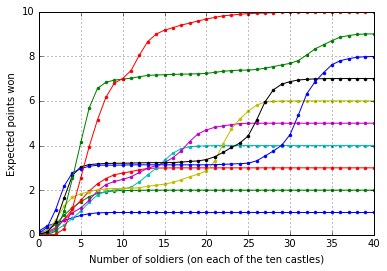

In [22]:
plotter(plans2)

We see that many castles (e.g. 9 (green), 8 (blue), 7 (black), 6 (yellowish)) have two plateaus. Castle 7 (black) has a plateau at 3.5 points for 6 to 20 soldiers (suggesting that 6 soldiers is a good investment and 20 soldiers a bad investment), and then another plateau at 7 points for everything above 30 soldiers.

Now that we have an estimate of the opponents, we can use `hillclimbers` to try to find a plan that does well against all the others:

CPU times: user 5min 40s, sys: 1 s, total: 5min 41s
Wall time: 5min 42s
Top 10 of 1000 plans:
( 3,  8, 10, 18, 21,  3,  5,  6, 10, 16)  99.9%
( 1,  9, 10, 17, 21,  6,  4,  6,  9, 17)  99.9%
( 1,  8, 10, 18, 21,  4,  4,  6, 11, 17)  99.9%
( 0, 10, 10, 17, 20,  4,  5,  6,  7, 21)  99.9%
( 2, 11,  1, 16, 18,  7,  6,  6,  8, 25)  99.8%
( 1,  8, 11, 19, 20,  4,  6,  5,  7, 19)  99.8%
( 0,  1, 11, 15, 18,  7,  6,  5, 13, 24)  99.8%
( 2, 10,  1, 17, 18,  9,  5,  6,  8, 24)  99.8%
( 1,  9, 10, 17, 19,  4,  6,  6,  9, 19)  99.8%
( 0,  2, 11, 18, 21,  4,  6,  8,  8, 22)  99.8%


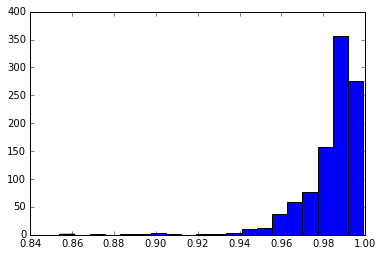

In [23]:
%time rankings3 = hillclimbers(plans2)
show(rankings3)

We can try even harder to improve the champ:

In [32]:
champ, _ = rankings3[0]
hillclimb(champ, plans2, 10000)

((3, 9, 10, 17, 21, 3, 5, 6, 7, 19), 1)

Here are some champion plans from previous runs of this notebook:

In [28]:
champs = {
 (0, 1, 3, 16, 20, 3, 4, 5, 32, 16),
 (0, 1, 9, 16, 15, 24, 5, 5, 8, 17),
 (0, 1, 9, 16, 16, 24, 5, 5, 7, 17),
 (0, 2, 9, 16, 15, 24, 5, 5, 8, 16),
 (0, 2, 9, 16, 15, 25, 5, 4, 7, 17),
 (0, 3, 4, 7, 16, 24, 4, 34, 4, 4),
 (0, 3, 5, 6, 20, 4, 4, 33, 8, 17),
 (0, 4, 5, 7, 20, 4, 4, 33, 7, 16),
 (0, 4, 6, 7, 19, 4, 4, 31, 8, 17),
 (0, 4, 12, 18, 21, 7, 6, 4, 8, 20),
 (0, 4, 12, 19, 25, 4, 5, 6, 8, 17),
 (0, 5, 6, 7, 18, 4, 5, 32, 7, 16),
 (0, 5, 7, 3, 18, 4, 4, 34, 8, 17),
 (1, 2, 9, 16, 15, 24, 5, 4, 7, 17),
 (1, 2, 9, 16, 15, 24, 5, 4, 8, 16),
 (1, 2, 11, 16, 15, 24, 5, 4, 7, 15),
 (1, 3, 14, 18, 24, 4, 5, 6, 8, 17),
 (1, 6, 3, 16, 16, 24, 5, 5, 7, 17),
 (2, 3, 7, 16, 16, 25, 5, 5, 8, 13),
 (2, 3, 8, 16, 12, 25, 5, 4, 8, 17),
 (2, 3, 8, 16, 15, 24, 5, 4, 7, 16),
 (2, 3, 8, 16, 15, 25, 4, 5, 8, 14),
 (2, 3, 8, 16, 16, 24, 5, 5, 8, 13),
 (2, 3, 9, 15, 12, 25, 4, 5, 8, 17),
 (2, 3, 9, 16, 12, 24, 5, 5, 8, 16),
 (2, 4, 12, 18, 24, 4, 6, 5, 8, 17),
 (3, 3, 7, 16, 16, 24, 5, 5, 8, 13),
 (3, 3, 8, 16, 12, 25, 4, 4, 8, 17),
 (3, 3, 8, 16, 15, 25, 5, 4, 7, 14),
 (3, 4, 12, 18, 23, 4, 6, 5, 8, 17),
 (3, 4, 15, 18, 23, 4, 5, 6, 8, 14),
 (3, 5, 7, 16, 5, 4, 5, 34, 7, 14),
 (3, 6, 13, 17, 23, 4, 6, 5, 8, 15),
 (4, 3, 12, 18, 23, 4, 5, 6, 8, 17),
 (4, 5, 3, 15, 11, 23, 5, 5, 10, 19),
 (4, 6, 3, 16, 14, 25, 5, 5, 8, 14),
 (4, 6, 3, 16, 16, 24, 5, 5, 7, 14),
 (4, 6, 3, 16, 16, 24, 5, 5, 8, 13),
 (5, 3, 12, 17, 23, 4, 5, 6, 8, 17),
 (5, 5, 3, 16, 12, 25, 4, 5, 8, 17),
 (5, 6, 3, 16, 16, 24, 5, 5, 7, 13),
 (5, 6, 7, 3, 21, 4, 27, 5, 8, 14),
 (5, 6, 8, 3, 18, 4, 27, 5, 8, 16),
 (5, 6, 8, 3, 20, 4, 27, 5, 8, 14),
 (5, 6, 8, 3, 21, 4, 27, 5, 8, 13)}

We can evaluate each of them against the original `plans`, against the improved `plans2`, against their fellow champs, and against all of those put together:

In [33]:
def μ(plan, plans): return pct(mean_points(plan,plans))
all = plans | plans2 | champs

print('Plan                                      plans plans2 champs  all')
for p in sorted(champs, key=lambda p: -mean_points(p, all)):
    print(pplan(p), μ(p, plans), μ(p, plans2), μ(p, champs), μ(p, all))

Plan                                      plans plans2 champs  all
( 0,  5,  7,  3, 18,  4,  4, 34,  8, 17)  85.5%  96.0%  68.5%  90.2%
( 0,  4,  6,  7, 19,  4,  4, 31,  8, 17)  84.7%  95.0%  63.0%  89.2%
( 0,  1,  3, 16, 20,  3,  4,  5, 32, 16)  85.6%  95.2%  31.5%  89.0%
( 0,  3,  5,  6, 20,  4,  4, 33,  8, 17)  84.1%  95.2%  60.9%  89.0%
( 0,  5,  6,  7, 18,  4,  5, 32,  7, 16)  84.3%  96.3%  28.3%  88.9%
( 3,  5,  7, 16,  5,  4,  5, 34,  7, 14)  85.2%  95.7%  18.5%  88.8%
( 5,  6,  8,  3, 18,  4, 27,  5,  8, 16)  81.8%  96.4%  64.1%  88.6%
( 0,  4,  5,  7, 20,  4,  4, 33,  7, 16)  84.7%  95.0%  18.5%  88.2%
( 5,  6,  8,  3, 20,  4, 27,  5,  8, 14)  82.0%  96.2%  48.9%  88.2%
( 0,  1,  9, 16, 15, 24,  5,  5,  8, 17)  78.2%  98.6%  72.8%  88.0%
( 5,  6,  7,  3, 21,  4, 27,  5,  8, 14)  81.8%  96.0%  51.1%  88.0%
( 0,  1,  9, 16, 16, 24,  5,  5,  7, 17)  79.1%  98.5%  46.7%  87.8%
( 5,  6,  8,  3, 21,  4, 27,  5,  8, 13)  82.0%  95.2%  45.7%  87.6%
( 2,  3,  9, 15, 12, 25,  4,  5,  8,

Which plan is best? In the end, we don't know, because we don't know the pool we will be competing against.